In [5]:
import os
import pandas as pd
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import datetime
from scipy.interpolate import interp1d
import seaborn as sns

In [6]:
south_africa_path = "C:/Users/KatharinaG/Documents/South_Africa"

In [7]:
col_refuel7 = sns.color_palette(["#c72321","#861719","#f0c320","#af8f19","#6e9b9e","#0d8085","#19484c"])
col_refuel3 = sns.color_palette(["#c72321", "#0d8085", "#efc220"])
col_refuel5 = sns.color_palette(["#c62220", "#fbd7a8", "#7a6952", "#0d8085", "#f0c220"])
col_refuel10 = sns.color_palette(["#c72321","#861719","#fbd7a9","#ba9f7c","#7a6952","#6e9b9e","#0d8085","#19484c","#f0c320","#af8f19"])


In [8]:
rea_path = "C:/Users/KatharinaG/Data/era5/ZAF"

chk = {
    "time" : 36
}
data = xr.open_mfdataset(rea_path+"/*.nc",chunks=chk)

load locations of wind power plants

In [9]:
windparks = pd.read_csv(south_africa_path+"/windparks_southafrica.csv",delimiter=';') 

extract years, months and days of commissioning dates, if month not given set to 6, if day not given set to 15

In [10]:
y = np.array([x[:4] for x in windparks.commissioning])

In [11]:
m = np.array([x[5:7] for x in windparks.commissioning])
m[m==''] = '06'

In [12]:
d = np.array([x[8:10] for x in windparks.commissioning])
d[d==''] = '15'

join years, months and days to datetime format

In [13]:
t = [np.datetime64(y[i]+'-'+m[i]+'-'+d[i]+"T00:00:00") for i in np.arange(len(y))]

extract longitudes and latitudes of locations of wind parks

In [14]:
lons = windparks.Longitude
lats = windparks.Latitude

interpolate wind speeds to locations of wind parks, store in list and concatenate to xarray dataset

In [15]:
wind_windparks = data.interp(coords={"longitude":xr.DataArray(lons,dims='location'),
                                     "latitude":xr.DataArray(lats,dims='location')},method="nearest")

# Inter- and extrapolation of wind speeds to hub height (108 m)

calculate wind at 10 and 50m height with pythagoras form u and v wind speed component

\begin{equation*}
v_{eff} = \sqrt{u^2+v^2}
\end{equation*}

In [16]:
# wind in 10m height calculated from u and v component
windh10 = np.sqrt(wind_windparks.v10.values**2 + wind_windparks.u10.values**2)
# wind in 100m height calculated from u and v component
windh100 = np.sqrt(wind_windparks.v100.values**2 + wind_windparks.u100.values**2)

C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\scipy\interpolate\interpolate.py:2514: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.values[idx_res]


calculate alpha friction coefficient

\begin{equation*}
\alpha = \frac{(ln(v_2/v_1)}{(ln(h_2/h_1))}
\end{equation*}

In [17]:
alpha = (np.log(windh100/windh10))/(np.log(100/10))


then calculate wind speed at height 108m (height of Enercon E-82)

\begin{equation*}
v_2 = v_1 * \Bigl(\frac{h_2}{h_1}\Bigr)^\alpha
\end{equation*}

In [18]:
turbine_height = 108
windh108 = windh10 * (turbine_height/10)**alpha

# calculate wind power generation from wind speeds

Enercon E-82 power curve (https://www.enercon.de/fileadmin/Redakteur/Medien-Portal/broschueren/pdf/en/ENERCON_Produkt_en_06_2015.pdf)

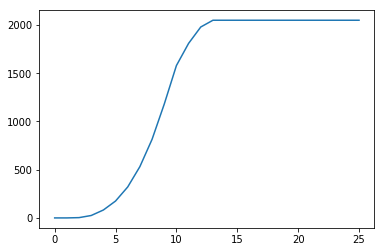

In [19]:
wind_speeds = (np.arange(0, 26, step=1.0))
generation_kw = [0.0, 0.000000000001, 3.0, 25.0, 82.0, 175.0, 321.0, 532.0, 815.0, 1180.0, 1580.0, 1810.0, 1980.0] + 13 * [2050.0]
plt.plot(wind_speeds,generation_kw)

In [20]:
# which share of wind speeds is higher than 25 m/s?
len(windh108[windh108>25])/(len(windh108))

0.0

create power curve function, which linearly interpolates between power curve points

In [21]:
power_curve = interp1d(wind_speeds, generation_kw)

calculate wind power generation

In [22]:
wp1 = xr.apply_ufunc(power_curve, windh108,
                     dask='parallelized',
                     output_dtypes=[np.float64])
# fetch installed capacity and divide by 2000 to make factor for capacity of Enercon E-82
cap = list(windparks.Capacity/2000.0)
# multiply with installed capacity
wp2 = cap*wp1


In [23]:
# function which "commissions" wind park : before commissioning production is set to 0
# parameters:
# - date1: commissioning date, dtype datetime64
# - timeseries: time series of period, dtype datetime64
# - windpower: wind power scaled by installed capacity, length same as timeseries
def commission(date1,timeseries,windpower):
    bin_sel = np.zeros(len(timeseries))
    bin_sel[timeseries >= date1] = 1
    out = windpower * bin_sel
    return out

In [24]:
# prepare array for commissioned wind power
wp3 = np.zeros(wp2.shape)
# make wind power generation start at commissioning date
for i in np.arange(len(t)):
    wp3[:,i] = commission(t[i],wind_windparks.time.values,wp2[:,i])

make into xarray dataset

In [25]:
idx = pd.MultiIndex.from_arrays([lons,
                                 lats],
                                 names=['lon', 'lat'])

windpower_windparks = xr.DataArray(wp3,coords={'time':wind_windparks.time.values,'location':idx},dims=('time','location')).to_dataset(name='wind_power')

In [26]:
# save data
windpower_windparks_newind = windpower_windparks.copy(deep=True)
windpower_windparks_newind = windpower_windparks_newind.reset_index('location')
windpower_windparks_newind.to_netcdf(south_africa_path+"/results/windpower_ZAF_ERA5.nc")

# Get Global Wind Atlas data

use rasterio, it's the easiest way and directly makes it into an xarray for easy interpolation

In [27]:
GWA = xr.open_rasterio(south_africa_path+'/GWA_ZAF.tif')

interpolate to locations of wind turbines

In [28]:
GWA_locations = GWA.interp(coords={"x":xr.DataArray(lons,dims='location'),
                                   "y":xr.DataArray(lats,dims='location')},method="nearest")

C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\scipy\interpolate\interpolate.py:2514: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.values[idx_res]


calculate correction factor wind speeds by division

In [29]:
corr_fac_GWA = GWA_locations.values/windh100.mean(axis=0)


apply correction factor

In [30]:
windh108_GWA = windh108 * corr_fac_GWA

calculate wind power generation like before

In [31]:
# which share of wind is above 25 m/s?
len(windh108_GWA[windh108_GWA>25])/len(windh108_GWA)

0.0002566735112936345

In [32]:
# here we have a little share of wind speeds above 25m/s -> set these  to 25 m/s
windh108_GWA[windh108_GWA>25] = 25

In [33]:
wp1_GWA = xr.apply_ufunc(power_curve, windh108_GWA,
                     dask='parallelized',
                     output_dtypes=[np.float64])
# fetch installed capacity and divide by 2000 to make factor for capacity of Enercon E-82
cap = list(windparks.Capacity/2000.0)
# multiply with installed capacity
wp2_GWA = cap*wp1_GWA
wp3_GWA = np.zeros(wp2_GWA.shape)
# make wind power generation start at commissioning date
for i in np.arange(len(t)):
    wp3_GWA[:,i] = commission(t[i],wind_windparks.time.values,wp2_GWA[:,i])
windpower_windparks_GWA = xr.DataArray(wp3_GWA,coords={'time':wind_windparks.time.values,'location':idx},dims=('time','location')).to_dataset(name='wind_power')


# Sum up capes

extract the indices of locations from different areas

In [34]:
ind_nc = np.where(windparks.Area=='Northern Cape')
ind_ec = np.where(windparks.Area=='Eastern Cape')
ind_wc = np.where(windparks.Area=='Western Cape')

sum the wind power generation for these regions

In [35]:
windpower_kW_area = pd.DataFrame({'Northern_Cape':np.sum(windpower_windparks.isel(location=ind_nc[0].tolist()).wind_power.values,axis = 1),
                                  'Eastern_Cape':np.sum(windpower_windparks.isel(location=ind_ec[0].tolist()).wind_power.values,axis = 1),
                                  'Western_Cape':np.sum(windpower_windparks.isel(location=ind_wc[0].tolist()).wind_power.values,axis = 1)},
                                   index = windpower_windparks.time.values)


In [36]:
windpower_kW_area_GWA = pd.DataFrame({'Northern_Cape':np.sum(windpower_windparks_GWA.isel(location=ind_nc[0].tolist()).wind_power.values,axis = 1),
                                      'Eastern_Cape':np.sum(windpower_windparks_GWA.isel(location=ind_ec[0].tolist()).wind_power.values,axis = 1),
                                      'Western_Cape':np.sum(windpower_windparks_GWA.isel(location=ind_wc[0].tolist()).wind_power.values,axis = 1)},
                                      index = windpower_windparks_GWA.time.values)


# Load production data

In [37]:
# Load data Eastern Cape
data_ec = []
for year in range(2014,2019):
    datay = pd.read_csv(south_africa_path+"/production/EasternCape/Hourly_Electricity_production_[Load_Factor_[[%]]_data"+str(year)+".csv",delimiter=';') 
    if(len(data_ec)):
        data_ec = pd.concat([data_ec,datay])
    else:
        data_ec = datay

# Load data Western Cape
data_wc = []
for year in range(2015,2019):
    datay = pd.read_csv(south_africa_path+"/production/WesternCape/Hourly_Electricity_production_[Load_Factor_[[%]]_data"+str(year)+".csv",delimiter=';') 
    if(len(data_wc)):
        data_wc = pd.concat([data_wc,datay])
    else:
        data_wc = datay
        
# Load data Northern Cape
data_nc = []
for year in range(2017,2019):
    datay = pd.read_csv(south_africa_path+"/production/NorthernCape/Hourly_Electricity_production_[Load_Factor_[[%]]_data"+str(year)+".csv",delimiter=';') 
    if(len(data_nc)):
        data_nc = pd.concat([data_nc,datay])
    else:
        data_nc = datay

create pandas dataframes for each of the locations

In [38]:
# Eastern Cape
y = np.array([data_ec['Settlement DateTime'].iloc[x][6:10] for x in range(data_ec.shape[0])])
m = np.array([data_ec['Settlement DateTime'].iloc[x][3:5] for x in range(data_ec.shape[0])])
d = np.array([data_ec['Settlement DateTime'].iloc[x][:2] for x in range(data_ec.shape[0])])
h = np.array([data_ec['Settlement DateTime'].iloc[x][11:13] for x in range(data_ec.shape[0])])
t1 = [np.datetime64(y[i]+'-'+m[i]+'-'+d[i]+"T"+h[i]+":00:00") for i in np.arange(len(y))]
# create dataframe with datetime index and simulated data and create column to fill in historical data
production_MW_ec = pd.DataFrame({'wp_MWh':data_ec['Production MWh'].tolist(),
                                 'sim_wp_MWh':np.nan,
                                 'sim_wp_MWh_GWA':np.nan},index=t1)

# Western Cape
y = np.array([data_wc['Settlement DateTime'].iloc[x][6:10] for x in range(data_wc.shape[0])])
m = np.array([data_wc['Settlement DateTime'].iloc[x][3:5] for x in range(data_wc.shape[0])])
d = np.array([data_wc['Settlement DateTime'].iloc[x][:2] for x in range(data_wc.shape[0])])
h = np.array([data_wc['Settlement DateTime'].iloc[x][11:13] for x in range(data_wc.shape[0])])
t1 = [np.datetime64(y[i]+'-'+m[i]+'-'+d[i]+"T"+h[i]+":00:00") for i in np.arange(len(y))]
# create dataframe with datetime index and simulated data and create column to fill in historical data
production_MW_wc = pd.DataFrame({'wp_MWh':data_wc['Production MWh'].tolist(),
                                 'sim_wp_MWh':np.nan,
                                 'sim_wp_MWh_GWA':np.nan},index=t1)

# Northern Cape
y = np.array([data_nc['Settlement DateTime'].iloc[x][6:10] for x in range(data_nc.shape[0])])
m = np.array([data_nc['Settlement DateTime'].iloc[x][3:5] for x in range(data_nc.shape[0])])
d = np.array([data_nc['Settlement DateTime'].iloc[x][:2] for x in range(data_nc.shape[0])])
h = np.array([data_nc['Settlement DateTime'].iloc[x][11:13] for x in range(data_nc.shape[0])])
t1 = [np.datetime64(y[i]+'-'+m[i]+'-'+d[i]+"T"+h[i]+":00:00") for i in np.arange(len(y))]
# create dataframe with datetime index and simulated data and create column to fill in historical data
production_MW_nc = pd.DataFrame({'wp_MWh':data_nc['Production MWh'].tolist(),
                                 'sim_wp_MWh':np.nan,
                                 'sim_wp_MWh_GWA':np.nan},index=t1)

# Fill in simulated data and sort

In [39]:
# fill in simulated data - cannot be added simply as other column, as in historical data some time steps are missing
# therefore match simulated data to time steps
production_MW_ec.sim_wp_MWh = production_MW_ec.index.map(windpower_kW_area.Eastern_Cape)
production_MW_wc.sim_wp_MWh = production_MW_wc.index.map(windpower_kW_area.Western_Cape)
production_MW_nc.sim_wp_MWh = production_MW_nc.index.map(windpower_kW_area.Northern_Cape)

In [40]:
# fill in GWA simulation
production_MW_ec.sim_wp_MWh_GWA = production_MW_ec.index.map(windpower_kW_area_GWA.Eastern_Cape)
production_MW_wc.sim_wp_MWh_GWA = production_MW_wc.index.map(windpower_kW_area_GWA.Western_Cape)
production_MW_nc.sim_wp_MWh_GWA = production_MW_nc.index.map(windpower_kW_area_GWA.Northern_Cape)


In [41]:
# sort by datetime index
production_MW_ec = production_MW_ec.sort_index()
production_MW_wc = production_MW_wc.sort_index()
production_MW_nc = production_MW_nc.sort_index()

### Available data - incomplete historical generation

In [42]:
available_data = pd.DataFrame({'EC':0,'NC':0,'WC':0,'ZAF':0},index=windpower_windparks.time.values)

In [43]:
# fill in generation data
available_data.EC = np.invert([np.isnan(i) for i in available_data.index.map(production_MW_ec.sim_wp_MWh)]).astype(int)
available_data.NC = np.invert([np.isnan(i) for i in available_data.index.map(production_MW_nc.sim_wp_MWh)]).astype(int)
available_data.WC = np.invert([np.isnan(i) for i in available_data.index.map(production_MW_wc.sim_wp_MWh)]).astype(int)

In [45]:
# for data availability in ZAF, we need to know in how many regions there was production at each time
producing_regions = pd.DataFrame({'EC':1,'NC':1,'WC':1,'ZAF':0},index=windpower_windparks.time.values)

In [46]:
# set production 0 before recorded production
producing_regions.EC[producing_regions.index<production_MW_ec.index.min()] = 0
producing_regions.NC[producing_regions.index<production_MW_nc.index.min()] = 0
producing_regions.WC[producing_regions.index<production_MW_wc.index.min()] = 0

# producing regions in ZAF are sum of production in three regions
producing_regions.ZAF = producing_regions.EC + producing_regions.NC + producing_regions.WC
# set where no producing regions to -1
producing_regions.ZAF[producing_regions.ZAF==0] = -1

In [47]:
available_data.ZAF = np.array([int(i==0) for i in (available_data.EC + available_data.NC + available_data.WC - producing_regions.ZAF)])

# Data selection - only use timespans where all data are available

In [48]:
# only do for timespans where data are available for ALL regions (ZAF data available = 1)
production_MW_ec_ts = production_MW_ec[production_MW_ec.index.map(available_data.ZAF)==1]
production_MW_nc_ts = production_MW_nc[production_MW_nc.index.map(available_data.ZAF)==1]
production_MW_wc_ts = production_MW_wc[production_MW_wc.index.map(available_data.ZAF)==1]

In [49]:
# prepare dataframe for summing up
production_MW_all = pd.DataFrame({'wp_MWh_EC':0, 'sim_wp_MWh_EC':0, 'sim_wp_MWh_EC_GWA':0,
                                  'wp_MWh_NC':0, 'sim_wp_MWh_NC':0, 'sim_wp_MWh_NC_GWA':0,
                                  'wp_MWh_WC':0, 'sim_wp_MWh_WC':0, 'sim_wp_MWh_WC_GWA':0},
                                  index = windpower_windparks.time.values[available_data.ZAF==1])
production_MW_all.wp_MWh_EC = production_MW_all.index.map(production_MW_ec_ts.wp_MWh)
production_MW_all.sim_wp_MWh_EC = production_MW_all.index.map(production_MW_ec_ts.sim_wp_MWh)
production_MW_all.sim_wp_MWh_EC_GWA = production_MW_all.index.map(production_MW_ec_ts.sim_wp_MWh_GWA)

production_MW_all.wp_MWh_NC = production_MW_all.index.map(production_MW_nc_ts.wp_MWh)
production_MW_all.sim_wp_MWh_NC = production_MW_all.index.map(production_MW_nc_ts.sim_wp_MWh)
production_MW_all.sim_wp_MWh_NC_GWA = production_MW_all.index.map(production_MW_nc_ts.sim_wp_MWh_GWA)

production_MW_all.wp_MWh_WC = production_MW_all.index.map(production_MW_wc_ts.wp_MWh)
production_MW_all.sim_wp_MWh_WC = production_MW_all.index.map(production_MW_wc_ts.sim_wp_MWh)
production_MW_all.sim_wp_MWh_WC_GWA = production_MW_all.index.map(production_MW_wc_ts.sim_wp_MWh_GWA)

In [50]:
# fill nans with 0
production_MW_all = production_MW_all.fillna(0)

In [51]:
# sum up for ZAF
production_MW_zaf_ts = pd.DataFrame({'wp_MWh':production_MW_all.wp_MWh_EC + production_MW_all.wp_MWh_NC + production_MW_all.wp_MWh_WC,
                                     'sim_wp_MWh':production_MW_all.sim_wp_MWh_EC + production_MW_all.sim_wp_MWh_NC + production_MW_all.sim_wp_MWh_WC,
                                     'sim_wp_MWh_GWA':production_MW_all.sim_wp_MWh_EC_GWA + production_MW_all.sim_wp_MWh_NC_GWA + production_MW_all.sim_wp_MWh_WC_GWA},
                                     index=production_MW_all.index)

# statistical analysis hourly

In [781]:
# prepare dataframe for hourly statistical analysis
stats_h = pd.DataFrame({'cor':np.nan,
                        'rmse':np.nan,
                        'mbe':np.nan,
                        'avg':np.nan},
                        index = ['EC','EC_GWA','EC_obs',
                                 'NC','NC_GWA','NC_obs',
                                 'WC','WC_GWA','WC_obs',
                                 'ZAF','ZAF_GWA','ZAF_obs'])

Calculate correlations

In [782]:
stats_h.cor = [np.corrcoef(production_MW_ec_ts.wp_MWh,production_MW_ec_ts.sim_wp_MWh)[0,1],
               np.corrcoef(production_MW_ec_ts.wp_MWh,production_MW_ec_ts.sim_wp_MWh_GWA)[0,1],
               np.nan,
               np.corrcoef(production_MW_wc_ts.wp_MWh,production_MW_wc_ts.sim_wp_MWh)[0,1],
               np.corrcoef(production_MW_wc_ts.wp_MWh,production_MW_wc_ts.sim_wp_MWh_GWA)[0,1],
               np.nan,
               np.corrcoef(production_MW_nc_ts.wp_MWh,production_MW_nc_ts.sim_wp_MWh)[0,1],
               np.corrcoef(production_MW_nc_ts.wp_MWh,production_MW_nc_ts.sim_wp_MWh_GWA)[0,1],
               np.nan,
               np.corrcoef(production_MW_zaf_ts.wp_MWh,production_MW_zaf_ts.sim_wp_MWh)[0,1],
               np.corrcoef(production_MW_zaf_ts.wp_MWh,production_MW_zaf_ts.sim_wp_MWh_GWA)[0,1],
               np.nan]


Calculate RMSEs

In [783]:
stats_h.rmse = [np.sqrt(np.mean((np.array(production_MW_ec_ts.wp_MWh)-np.array(production_MW_ec_ts.sim_wp_MWh))**2)),
                 np.sqrt(np.mean((np.array(production_MW_ec_ts.wp_MWh)-np.array(production_MW_ec_ts.sim_wp_MWh_GWA))**2)),
                 np.nan,
                 np.sqrt(np.mean((np.array(production_MW_nc_ts.wp_MWh)-np.array(production_MW_nc_ts.sim_wp_MWh))**2)),
                 np.sqrt(np.mean((np.array(production_MW_nc_ts.wp_MWh)-np.array(production_MW_nc_ts.sim_wp_MWh_GWA))**2)),
                 np.nan,
                 np.sqrt(np.mean((np.array(production_MW_wc_ts.wp_MWh)-np.array(production_MW_wc_ts.sim_wp_MWh))**2)),
                 np.sqrt(np.mean((np.array(production_MW_wc_ts.wp_MWh)-np.array(production_MW_wc_ts.sim_wp_MWh_GWA))**2)),
                 np.nan,
                 np.sqrt(np.mean((np.array(production_MW_zaf_ts.wp_MWh)-np.array(production_MW_zaf_ts.sim_wp_MWh))**2)),
                 np.sqrt(np.mean((np.array(production_MW_zaf_ts.wp_MWh)-np.array(production_MW_zaf_ts.sim_wp_MWh_GWA))**2)),
                 np.nan]


Calculate MBEs

In [784]:
stats_h.mbe = [(np.array(production_MW_ec_ts.sim_wp_MWh)-np.array(production_MW_ec_ts.wp_MWh)).mean(),
               (np.array(production_MW_ec_ts.sim_wp_MWh_GWA)-np.array(production_MW_ec_ts.wp_MWh)).mean(),
               np.nan,
               (np.array(production_MW_nc_ts.sim_wp_MWh)-np.array(production_MW_nc_ts.wp_MWh)).mean(),
               (np.array(production_MW_nc_ts.sim_wp_MWh_GWA)-np.array(production_MW_nc_ts.wp_MWh)).mean(),
               np.nan,
               (np.array(production_MW_wc_ts.sim_wp_MWh)-np.array(production_MW_wc_ts.wp_MWh)).mean(),
               (np.array(production_MW_wc_ts.sim_wp_MWh_GWA)-np.array(production_MW_wc_ts.wp_MWh)).mean(),
               np.nan,
               (np.array(production_MW_zaf_ts.sim_wp_MWh)-np.array(production_MW_zaf_ts.wp_MWh)).mean(),
               (np.array(production_MW_zaf_ts.sim_wp_MWh_GWA)-np.array(production_MW_zaf_ts.wp_MWh)).mean(),
               np.nan]


Calculate means

In [785]:
stats_h.avg = [production_MW_ec_ts.sim_wp_MWh.mean(),production_MW_ec_ts.sim_wp_MWh_GWA.mean(),production_MW_ec_ts.wp_MWh.mean(),
               production_MW_nc_ts.sim_wp_MWh.mean(),production_MW_nc_ts.sim_wp_MWh_GWA.mean(),production_MW_nc_ts.wp_MWh.mean(),
               production_MW_wc_ts.sim_wp_MWh.mean(),production_MW_wc_ts.sim_wp_MWh_GWA.mean(),production_MW_wc_ts.wp_MWh.mean(),
               production_MW_zaf_ts.sim_wp_MWh.mean(),production_MW_zaf_ts.sim_wp_MWh_GWA.mean(),production_MW_zaf_ts.wp_MWh.mean()]


save dataframe with hourly results

In [786]:
# hourly and absolute statistics
stats_ha = stats_h.transpose().set_index(pd.Index(['Correlation','RMSE_MWh','MBE_MWh','Mean_MWh']),'parameter')

In [787]:
stats_ha.round(2)

,EC,EC_GWA,EC_obs,NC,NC_GWA,NC_obs,WC,WC_GWA,WC_obs,ZAF,ZAF_GWA,ZAF_obs
Correlation,0.84,0.86,NaN,0.78,0.79,NaN,0.70,0.70,NaN,0.88,0.89,NaN
RMSE_MWh,119.20,113.26,NaN,109.61,110.10,NaN,65.20,64.47,NaN,145.19,137.39,NaN
MBE_MWh,-54.11,-15.04,NaN,-6.14,4.20,NaN,-26.60,-4.26,NaN,-76.28,-18.26,NaN
Mean_MWh,180.70,219.76,234.81,195.58,205.92,201.72,101.53,123.86,128.13,276.54,334.56,352.81


In [788]:
stats_ha.round(2).to_csv(south_africa_path+'/results/stats_h_abs_ERA5.csv',sep=';')

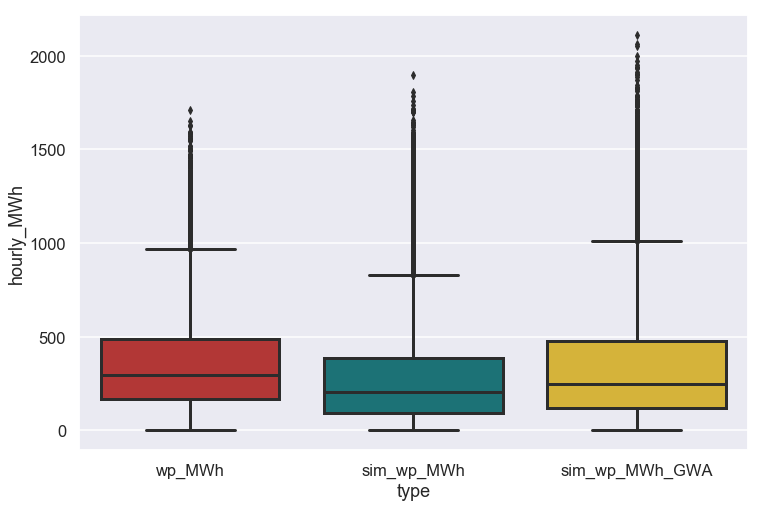

In [820]:
# plot ZAF
prod_ZAFh = production_MW_zaf_ts.melt(var_name='type',value_name='hourly_MWh')
sns.set(style='darkgrid',context='talk')
plt.figure(figsize=(12,8))
ax = sns.boxplot(x='type',y='hourly_MWh',data=prod_ZAFh,palette=col_refuel3,linewidth=3)
#plt.ylim(0,1)
fig = ax.get_figure()
fig.savefig(south_africa_path+'/results/plots/absolute/ZAF_ERA5_hourly.png')

In [790]:
# boxplots with seaborn for capes

# melt data for each region and add a region column
prod_ECh = production_MW_ec_ts.melt(var_name='type',value_name='hourly_MWh')
prod_ECh['region'] = 'EC'
prod_NCh = production_MW_nc_ts.melt(var_name='type',value_name='hourly_MWh')
prod_NCh['region'] = 'NC'
prod_WCh = production_MW_wc_ts.melt(var_name='type',value_name='hourly_MWh')
prod_WCh['region'] = 'WC'

# merge regions to one data frame
prod_Ch = pd.concat([prod_ECh,prod_NCh,prod_WCh])

In [791]:
prod_Ch_tidy = prod_Ch.melt(id_vars=['region','type'],value_name='hourly_MWh').drop(columns={'variable'})

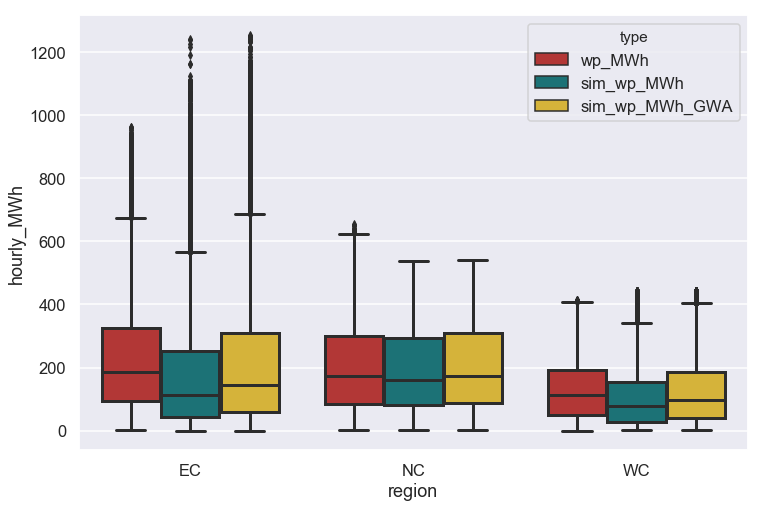

In [821]:
CF_ZAFh = CF_ZAF_h.melt(var_name='type',value_name='hourly_CF')
sns.set(style='darkgrid',context='talk')
plt.figure(figsize=(12,8))
ax = sns.boxplot(x='region',y='hourly_MWh',hue='type',data=prod_Ch_tidy,palette=col_refuel3,linewidth=3)
#plt.ylim(0,1)
fig = ax.get_figure()
fig.savefig(south_africa_path+'/results/plots/absolute/regions_ERA5_hourly.png')

# statistical analysis daily

Whole country: need to remove days which are not complete, then aggregate daily

In [52]:
# function which creates series of 0 and 1 when hours shall be kept (1, complete days with 24 hours)
# or hours shall be dropped (0, days where less than 24 hours are available)
def drop_less_one_day(datetimeindex):
    dt = np.array(datetimeindex.year*10000+datetimeindex.month*100+datetimeindex.day)
    length = np.unique(dt,return_counts=True)[1]
    
    filt = np.array([0]*len(length))
    filt[np.equal(length,24)] = 1
    code = np.repeat(filt,length)
    
    return code

In [53]:
print('Shares of data kept')
d = drop_less_one_day(production_MW_ec_ts.index)
print("EC keep %: ", round(sum(np.equal(d,1))/len(production_MW_ec_ts.index)*100,1))

d = drop_less_one_day(production_MW_wc_ts.index)
print("WC keep %: ", round(sum(np.equal(d,1))/len(production_MW_wc_ts.index)*100,1))

d = drop_less_one_day(production_MW_nc_ts.index)
print("NC keep %: ", round(sum(np.equal(d,1))/len(production_MW_nc_ts.index)*100,1))

d = drop_less_one_day(production_MW_zaf_ts.index)
print("ZAF keep %: ", round(sum(np.equal(d,1))/len(production_MW_zaf_ts.index)*100,1))


Shares of data kept
EC keep %:  67.9
WC keep %:  71.1
NC keep %:  70.4
ZAF keep %:  67.9


In [54]:
# first copy all the data, in order to avoid warning message
production_MW_ec_ts = production_MW_ec_ts.copy()
production_MW_nc_ts = production_MW_nc_ts.copy()
production_MW_wc_ts = production_MW_wc_ts.copy()
production_MW_zaf_ts = production_MW_zaf_ts.copy()

In [55]:
# mark the data to keep
production_MW_ec_ts['keep'] = drop_less_one_day(production_MW_ec_ts.index)
production_MW_wc_ts['keep'] = drop_less_one_day(production_MW_wc_ts.index)
production_MW_nc_ts['keep'] = drop_less_one_day(production_MW_nc_ts.index)
production_MW_zaf_ts['keep'] = drop_less_one_day(production_MW_zaf_ts.index)

In [56]:
# filter out only whole days
production_ec_filtered = production_MW_ec_ts[production_MW_ec_ts.keep==1]
production_wc_filtered = production_MW_wc_ts[production_MW_wc_ts.keep==1]
production_nc_filtered = production_MW_nc_ts[production_MW_nc_ts.keep==1]
production_zaf_filtered = production_MW_zaf_ts[production_MW_zaf_ts.keep==1]

### aggregate daily

In [798]:
date_ec = production_ec_filtered.index.year*10000+production_ec_filtered.index.month*100 + production_ec_filtered.index.day
production_GW_EC_daily = production_ec_filtered.groupby(date_ec).sum()/1000
date_nc = production_nc_filtered.index.year*10000+production_nc_filtered.index.month*100 + production_nc_filtered.index.day
production_GW_NC_daily = production_nc_filtered.groupby(date_nc).sum()/1000
date_wc = production_wc_filtered.index.year*10000+production_wc_filtered.index.month*100 + production_wc_filtered.index.day
production_GW_WC_daily = production_wc_filtered.groupby(date_wc).sum()/1000
date_zaf = production_zaf_filtered.index.year*10000+production_zaf_filtered.index.month*100 + production_zaf_filtered.index.day
production_GW_ZAF_daily = production_zaf_filtered.groupby(date_zaf).sum()/1000

In [799]:
production_GW_EC_daily = production_GW_EC_daily.drop('keep',axis=1).rename(columns={'wp_MWh':'obs','sim_wp_MWh':'sim','sim_wp_MWh_GWA':'sim_GWA'})
production_GW_NC_daily = production_GW_NC_daily.drop('keep',axis=1).rename(columns={'wp_MWh':'obs','sim_wp_MWh':'sim','sim_wp_MWh_GWA':'sim_GWA'})
production_GW_WC_daily = production_GW_WC_daily.drop('keep',axis=1).rename(columns={'wp_MWh':'obs','sim_wp_MWh':'sim','sim_wp_MWh_GWA':'sim_GWA'})
production_GW_ZAF_daily = production_GW_ZAF_daily.drop('keep',axis=1).rename(columns={'wp_MWh':'obs','sim_wp_MWh':'sim','sim_wp_MWh_GWA':'sim_GWA'})

### calculate statistical parameters
prepare dataframe for statistical parameters

In [800]:
stats_d = pd.DataFrame({'cor':np.nan,
                        'rmse':np.nan,
                        'mbe':np.nan,
                        'avg':np.nan},
                        index = ['EC','EC_GWA','EC_obs',
                                 'NC','NC_GWA','NC_obs',
                                 'WC','WC_GWA','WC_obs',
                                 'ZAF','ZAF_GWA','ZAF_obs'])

Calculate correlations

In [801]:
stats_d.cor = [np.corrcoef(production_GW_EC_daily.obs,production_GW_EC_daily.sim)[0,1],
               np.corrcoef(production_GW_EC_daily.obs,production_GW_EC_daily.sim_GWA)[0,1],
               np.nan,
               np.corrcoef(production_GW_WC_daily.obs,production_GW_WC_daily.sim)[0,1],
               np.corrcoef(production_GW_WC_daily.obs,production_GW_WC_daily.sim_GWA)[0,1],
               np.nan,
               np.corrcoef(production_GW_NC_daily.obs,production_GW_NC_daily.sim)[0,1],
               np.corrcoef(production_GW_NC_daily.obs,production_GW_NC_daily.sim_GWA)[0,1],
               np.nan,
               np.corrcoef(production_GW_ZAF_daily.obs,production_GW_ZAF_daily.sim)[0,1],
               np.corrcoef(production_GW_ZAF_daily.obs,production_GW_ZAF_daily.sim_GWA)[0,1],
               np.nan]


Calculate RMSEs

In [802]:
stats_d.rmse = [np.sqrt(np.mean((np.array(production_GW_EC_daily.obs)-np.array(production_GW_EC_daily.sim))**2)),
                 np.sqrt(np.mean((np.array(production_GW_EC_daily.obs)-np.array(production_GW_EC_daily.sim_GWA))**2)),
                 np.nan,
                 np.sqrt(np.mean((np.array(production_GW_NC_daily.obs)-np.array(production_GW_NC_daily.sim))**2)),
                 np.sqrt(np.mean((np.array(production_GW_NC_daily.obs)-np.array(production_GW_NC_daily.sim_GWA))**2)),
                 np.nan,
                 np.sqrt(np.mean((np.array(production_GW_WC_daily.obs)-np.array(production_GW_WC_daily.sim))**2)),
                 np.sqrt(np.mean((np.array(production_GW_WC_daily.obs)-np.array(production_GW_WC_daily.sim_GWA))**2)),
                 np.nan,
                 np.sqrt(np.mean((np.array(production_GW_ZAF_daily.obs)-np.array(production_GW_ZAF_daily.sim))**2)),
                 np.sqrt(np.mean((np.array(production_GW_ZAF_daily.obs)-np.array(production_GW_ZAF_daily.sim_GWA))**2)),
                 np.nan]


Calculate MBEs

In [803]:
stats_d.mbe = [(np.array(production_GW_EC_daily.sim)-np.array(production_GW_EC_daily.obs)).mean(),
               (np.array(production_GW_EC_daily.sim_GWA)-np.array(production_GW_EC_daily.obs)).mean(),
               np.nan,
               (np.array(production_GW_NC_daily.sim)-np.array(production_GW_NC_daily.obs)).mean(),
               (np.array(production_GW_NC_daily.sim_GWA)-np.array(production_GW_NC_daily.obs)).mean(),
               np.nan,
               (np.array(production_GW_WC_daily.sim)-np.array(production_GW_WC_daily.obs)).mean(),
               (np.array(production_GW_WC_daily.sim_GWA)-np.array(production_GW_WC_daily.obs)).mean(),
               np.nan,
               (np.array(production_GW_ZAF_daily.sim)-np.array(production_GW_ZAF_daily.obs)).mean(),
               (np.array(production_GW_ZAF_daily.sim_GWA)-np.array(production_GW_ZAF_daily.obs)).mean(),
               np.nan]


Calculate means

In [804]:
stats_d.avg = [production_GW_EC_daily.sim.mean(),production_GW_EC_daily.sim_GWA.mean(),production_GW_EC_daily.obs.mean(),
               production_GW_NC_daily.sim.mean(),production_GW_NC_daily.sim_GWA.mean(),production_GW_NC_daily.obs.mean(),
               production_GW_WC_daily.sim.mean(),production_GW_WC_daily.sim_GWA.mean(),production_GW_WC_daily.obs.mean(),
               production_GW_ZAF_daily.sim.mean(),production_GW_ZAF_daily.sim_GWA.mean(),production_GW_ZAF_daily.obs.mean()]


save dataframe with daily results

In [805]:
# hourly and absolute statistics
stats_da = stats_d.transpose().set_index(pd.Index(['Correlation','RMSE_MWh','MBE_MWh','Mean_MWh']),'parameter')

In [806]:
stats_da.round(2).to_csv(south_africa_path+'/results/stats_d_abs_ERA5.csv',sep=';')

In [807]:
stats_da.round(2)

,EC,EC_GWA,EC_obs,NC,NC_GWA,NC_obs,WC,WC_GWA,WC_obs,ZAF,ZAF_GWA,ZAF_obs
Correlation,0.90,0.92,NaN,0.81,0.82,NaN,0.54,0.54,NaN,0.93,0.94,NaN
RMSE_MWh,2.10,1.65,NaN,2.00,1.96,NaN,1.21,1.03,NaN,2.71,2.04,NaN
MBE_MWh,-1.32,-0.32,NaN,-0.45,-0.20,NaN,-0.72,-0.11,NaN,-1.96,-0.43,NaN
Mean_MWh,4.74,5.74,6.06,4.85,5.11,5.3,2.87,3.47,3.58,7.52,9.06,9.48


boxplot for South Africa

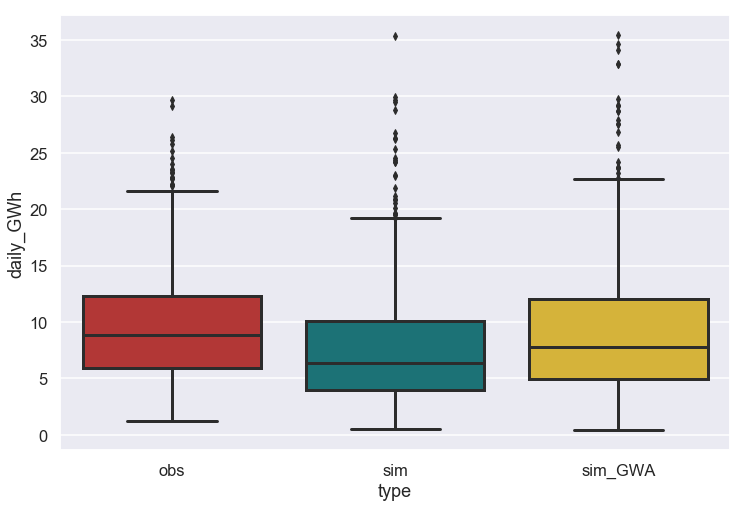

In [822]:
# plot South Africa
prod_ZAFd = production_GW_ZAF_daily.melt(var_name='type',value_name='daily_GWh')
sns.set(style='darkgrid',context='talk')
plt.figure(figsize=(12,8))
ax = sns.boxplot(x='type',y='daily_GWh',data=prod_ZAFd,palette=col_refuel3,linewidth=3)
fig = ax.get_figure()
fig.savefig(south_africa_path+'/results/plots/absolute/ZAF_ERA5_daily.png')

In [809]:
# boxplots for capes

# melt data for each region and add a region column
prod_ECd = production_GW_EC_daily.melt(var_name='type',value_name='daily_GWh')
prod_ECd['region'] = 'EC'
prod_NCd = production_GW_NC_daily.melt(var_name='type',value_name='daily_GWh')
prod_NCd['region'] = 'NC'
prod_WCd = production_GW_WC_daily.melt(var_name='type',value_name='daily_GWh')
prod_WCd['region'] = 'WC'

# merge regions to one data frame
prod_Cd = pd.concat([prod_ECd,prod_NCd,prod_WCd])

In [810]:
# lengths of time series
print('EC: '+str(prod_ECd.shape[0]))
print('NC: '+str(prod_NCd.shape[0]))
print('WC: '+str(prod_WCd.shape[0]))
print('ZAF: '+str(prod_ZAFd.shape[0]))

EC: 2484
NC: 168
WC: 2127
ZAF: 2484


In [811]:
prod_Cd_tidy = prod_Cd.melt(id_vars=['region','type'],value_name='daily_GWh').drop(columns={'variable'})

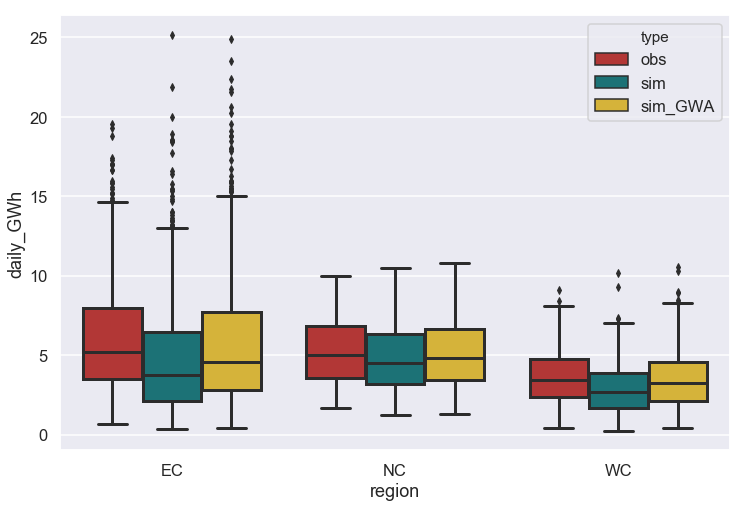

In [823]:
# plot Capes
sns.set(style='darkgrid',context='talk')
plt.figure(figsize=(12,8))
ax = sns.boxplot(x='region',y='daily_GWh',hue='type',data=prod_Cd_tidy,palette=col_refuel3,linewidth=3)
fig = ax.get_figure()
fig.savefig(south_africa_path+'/results/plots/absolute/regions_ERA5_daily.png')

# Conclusion absolute analysis

always better with GWA, with GWA only slightly underestimated, without GWA more underestimation

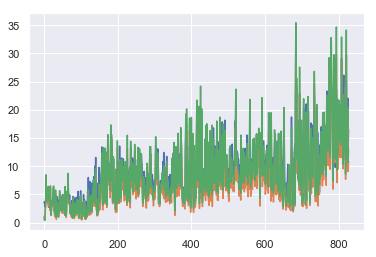

In [813]:
plt.plot(production_GW_ZAF_daily.iloc[:,:3].values)

# Installed Capacities

### make time series and get mean capacities

create time series of installed capacities

In [79]:
# sort installed capacities by commissioning date
cap = pd.DataFrame({'capacity': list(windparks.Capacity),'region':list(windparks.Area)},index=t)
cap = cap.sort_index()

In [80]:
# cumulative capacity EC
cap_ec = cap[cap.region=='Eastern Cape']
cap_ec = cap_ec.drop(columns={'region'}).groupby(cap_ec.index).sum()
cap_ec['capsum'] = cap_ec.capacity.cumsum()

In [81]:
# cumulative capacity NC
cap_nc = cap[cap.region=='Northern Cape']
cap_nc = cap_nc.drop(columns={'region'}).groupby(cap_nc.index).sum()
cap_nc['capsum'] = cap_nc.capacity.cumsum()

In [82]:
# cumulative capacity WC
cap_wc = cap[cap.region=='Western Cape']
cap_wc = cap_wc.drop(columns={'region'}).groupby(cap_wc.index).sum()
cap_wc['capsum'] = cap_wc.capacity.cumsum()

C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


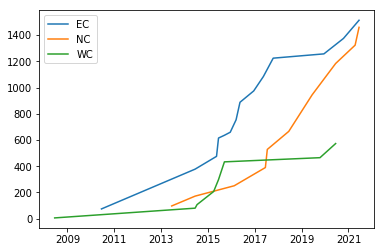

In [83]:
plt.plot(cap_ec.capsum)
plt.plot(cap_nc.capsum)
plt.plot(cap_wc.capsum)
plt.legend(['EC','NC','WC'])

get first capacity in period of interest

In [84]:
firstcap_ec = cap_ec[cap_ec.index<production_ec_filtered.index[0]].capsum[-1]
firstcap_nc = cap_nc[cap_nc.index<production_nc_filtered.index[0]].capsum[-1]
firstcap_wc = cap_wc[cap_wc.index<production_wc_filtered.index[0]].capsum[-1]

cut capacities after starting date of production

In [85]:
capc_ec = cap_ec[(cap_ec.index>=production_ec_filtered.index[0])&(cap_ec.index<=production_ec_filtered.index[-1])]
capc_nc = cap_nc[(cap_nc.index>=production_nc_filtered.index[0])&(cap_nc.index<=production_nc_filtered.index[-1])]
capc_wc = cap_wc[(cap_wc.index>=production_wc_filtered.index[0])&(cap_wc.index<=production_wc_filtered.index[-1])]


Make dataframe with dates where all data are available as index to fill in capacities and then sum for ZAF

In [86]:
cap_all_h = pd.DataFrame({'EC':0,'NC':0,'WC':0,'ZAF':0},index=available_data.index)

In [87]:
# fill in cumulative capacities
cap_all_h.EC = cap_all_h.index.map(capc_ec.capsum)
cap_all_h.NC = cap_all_h.index.map(capc_nc.capsum)
cap_all_h.WC = cap_all_h.index.map(capc_wc.capsum)

In [88]:
# fill in starting capacities at date of first observed generation
cap_all_h.at[production_MW_ec_ts.index[0],'EC'] = firstcap_ec
cap_all_h.at[production_MW_nc_ts.index[0],'NC'] = firstcap_nc
cap_all_h.at[production_MW_wc_ts.index[0],'WC'] = firstcap_wc

In [89]:
# fill Nas with last capacity
cap_all_h = cap_all_h.fillna(method = 'ffill')

In [90]:
# fill remaining Nas as beginning with 0
cap_all_h = cap_all_h.fillna(0)

In [91]:
# sum up capacities for ZAF
cap_all_h.ZAF = cap_all_h[['EC','NC','WC']].sum(axis=1)

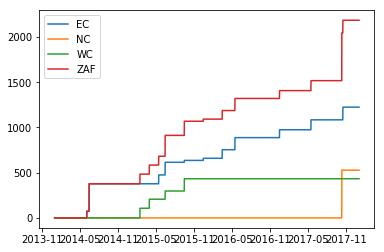

In [92]:
plt.plot(cap_all_h)
plt.legend(cap_all_h.columns)

In [93]:
# remove hours where not all data are available
cap_all_h = cap_all_h[available_data.ZAF==1]

In [94]:
# mean capacities
mcap_zaf = cap_all_h.ZAF.mean()
mcap_ec = cap_all_h.EC[cap_all_h.EC>0].mean()
mcap_nc = cap_all_h.NC[cap_all_h.NC>0].mean()
mcap_wc = cap_all_h.WC[cap_all_h.WC>0].mean()

### Daily capacities

In [558]:
# mark the data to keep
cap_all_h['keep'] = drop_less_one_day(cap_all_h.index)

In [559]:
# filter out only whole days
cap_all_h_filtered = cap_all_h[cap_all_h.keep==1]

get daily time series

In [560]:
date = cap_all_h_filtered.index.year*10000+cap_all_h_filtered.index.month*100 + cap_all_h_filtered.index.day
cap_all_d = cap_all_h_filtered.groupby(date).mean()

In [561]:
cap_all_d = cap_all_d.drop('keep',axis=1)

In [562]:
# mean capacities
mcap_zaf_d = cap_all_d.ZAF.mean()
mcap_ec_d = cap_all_d.EC[cap_all_d.EC>0].mean()
mcap_nc_d = cap_all_d.NC[cap_all_d.NC>0].mean()
mcap_wc_d = cap_all_d.WC[cap_all_d.WC>0].mean()

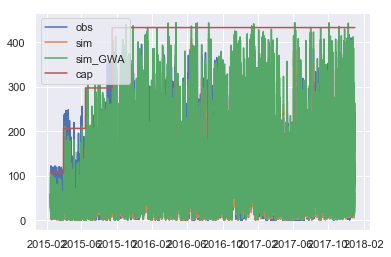

In [567]:
plt.plot(production_MW_wc[production_MW_wc.index<=max(cap_all_h.index)])
plt.plot(cap_all_h.WC[cap_all_h.WC>0])
plt.legend(['obs','sim','sim_GWA','cap'])

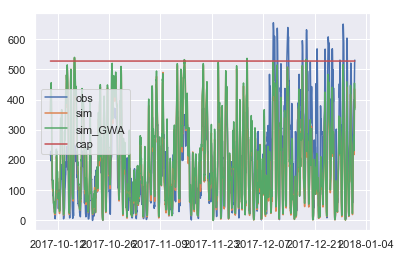

In [566]:
plt.plot(production_MW_nc[production_MW_nc.index<=max(cap_all_h.index)])
plt.plot(cap_all_h.NC[cap_all_h.NC>0])
plt.legend(['obs','sim','sim_GWA','cap'])

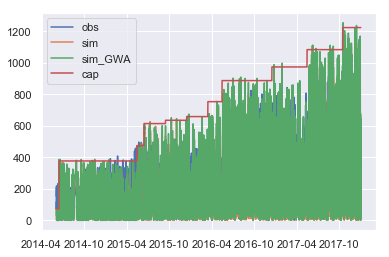

In [568]:
plt.plot(production_MW_ec[production_MW_ec.index<=max(cap_all_h.index)])
plt.plot(cap_all_h.EC[cap_all_h.EC>0])
plt.legend(['obs','sim','sim_GWA','cap'])

# Relative results

### hourly

In [586]:
stats_hr = stats_ha[['EC','EC_GWA','NC','NC_GWA','WC','WC_GWA','ZAF','ZAF_GWA']][:3].copy()

In [587]:
stats_hr.iloc[1:,:2] = stats_ha.iloc[1:3,:2]/(mcap_ec)

stats_hr.iloc[1:,2:4] = stats_ha.iloc[1:3,3:5]/(mcap_nc)

stats_hr.iloc[1:,4:6] = stats_ha.iloc[1:3,6:8]/(mcap_wc)

stats_hr.iloc[1:,6:8] = stats_ha.iloc[1:3,9:11]/(mcap_zaf)

In [588]:
stats_hr.round(2)

,EC,EC_GWA,NC,NC_GWA,WC,WC_GWA,ZAF,ZAF_GWA
Correlation,0.84,0.86,0.78,0.79,0.70,0.70,0.88,0.89
RMSE_MWh,0.16,0.15,0.21,0.21,0.17,0.16,0.13,0.12
MBE_MWh,-0.07,-0.02,-0.01,0.01,-0.07,-0.01,-0.07,-0.02


In [817]:
# save relative results
stats_hr.round(2).to_csv(south_africa_path+"/results/stats_h_rel_ERA5.csv")

### daily

In [590]:
stats_dr = stats_da[['EC','EC_GWA','NC','NC_GWA','WC','WC_GWA','ZAF','ZAF_GWA']][:3].copy()

In [591]:
stats_dr.iloc[1:,:2] = stats_da.iloc[1:3,:2]/(mcap_ec_d*24/1000)

stats_dr.iloc[1:,2:4] = stats_da.iloc[1:3,3:5]/(mcap_nc_d*24/1000)

stats_dr.iloc[1:,4:6] = stats_da.iloc[1:3,6:8]/(mcap_wc_d*24/1000)

stats_dr.iloc[1:,6:8] = stats_da.iloc[1:3,9:11]/(mcap_zaf_d*24/1000)

In [592]:
stats_dr.round(2)

,EC,EC_GWA,NC,NC_GWA,WC,WC_GWA,ZAF,ZAF_GWA
Correlation,0.90,0.92,0.81,0.82,0.54,0.54,0.93,0.94
RMSE_MWh,0.11,0.09,0.16,0.15,0.12,0.10,0.10,0.07
MBE_MWh,-0.07,-0.02,-0.04,-0.02,-0.07,-0.01,-0.07,-0.02


In [816]:
# save relative results
stats_dr.round(2).to_csv(south_africa_path+"/results/stats_d_rel_ERA5.csv")

# Capacity factors

let's also calculate daily and hourly capacity factors

### hourly

In [607]:
CF_EC_h = production_MW_ec_ts.drop('keep',axis=1).div(cap_all_h.EC[cap_all_h.EC>0].values,axis=0)
CF_NC_h = production_MW_nc_ts.drop('keep',axis=1).div(cap_all_h.NC[cap_all_h.NC>0].values,axis=0)
CF_WC_h = production_MW_wc_ts.drop('keep',axis=1).div(cap_all_h.WC[cap_all_h.WC>0].values,axis=0)
CF_ZAF_h = production_MW_zaf_ts.drop('keep',axis=1).div(cap_all_h.ZAF[cap_all_h.ZAF>0].values,axis=0)

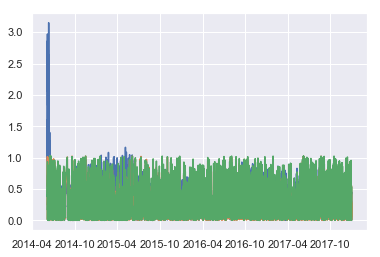

In [609]:
plt.plot(CF_EC_h)

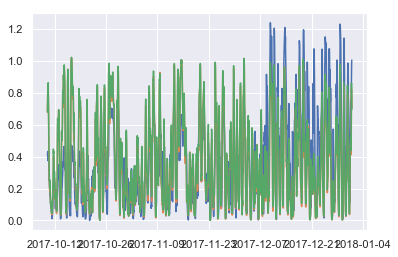

In [597]:
plt.plot(CF_NC_h)

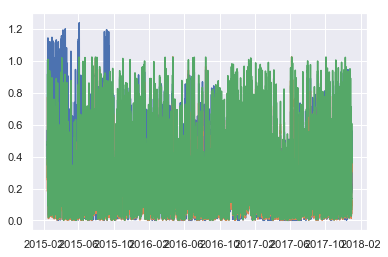

In [598]:
plt.plot(CF_WC_h)

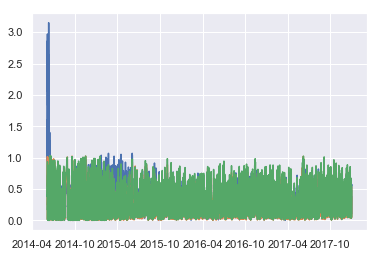

In [608]:
plt.plot(CF_ZAF_h)

### daily

In [641]:
CF_EC_d = production_GW_EC_daily.div(cap_all_d.EC[cap_all_d.EC>0].values*24/1000,axis=0)
CF_NC_d = production_GW_NC_daily.div(cap_all_d.NC[cap_all_d.NC>0].values*24/1000,axis=0)
CF_WC_d = production_GW_WC_daily.div(cap_all_d.WC[cap_all_d.WC>0].values*24/1000,axis=0)
CF_ZAF_d = production_GW_ZAF_daily.div(cap_all_d.ZAF[cap_all_d.ZAF>0].values*24/1000,axis=0)

In [642]:
CF_EC_d.index = [np.datetime64(str(d)[:4]+'-'+str(d)[4:6]+'-'+str(d)[6:]) for d in CF_EC_d.index]
CF_NC_d.index = [np.datetime64(str(d)[:4]+'-'+str(d)[4:6]+'-'+str(d)[6:]) for d in CF_NC_d.index]
CF_WC_d.index = [np.datetime64(str(d)[:4]+'-'+str(d)[4:6]+'-'+str(d)[6:]) for d in CF_WC_d.index]
CF_ZAF_d.index = [np.datetime64(str(d)[:4]+'-'+str(d)[4:6]+'-'+str(d)[6:]) for d in CF_ZAF_d.index]

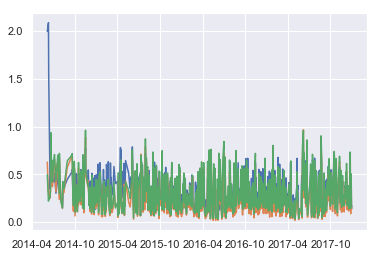

In [643]:
plt.plot(CF_EC_d)

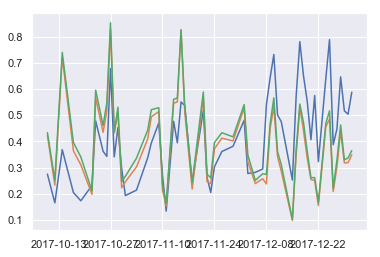

In [644]:
plt.plot(CF_NC_d)

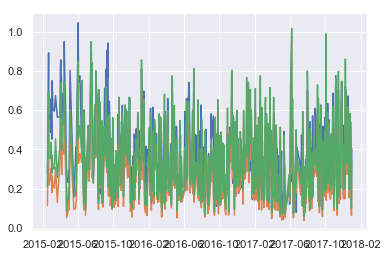

In [645]:
plt.plot(CF_WC_d)

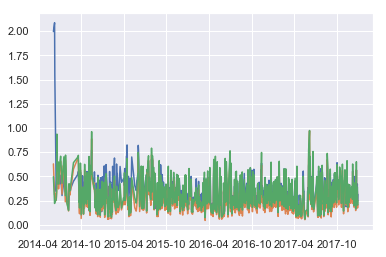

In [646]:
plt.plot(CF_ZAF_d)

# Analysis Capacity Factors

### hourly

In [721]:
statsCF_h = pd.DataFrame({'cor':np.nan,
                          'rmse':np.nan,
                          'mbe':np.nan,
                          'avg':np.nan},
                          index = ['EC','EC_GWA','EC_obs',
                                   'NC','NC_GWA','NC_obs',
                                   'WC','WC_GWA','WC_obs',
                                   'ZAF','ZAF_GWA','ZAF_obs'])

In [722]:
CF_EC_h.columns =['obs','sim','sim_GWA']
CF_NC_h.columns =['obs','sim','sim_GWA']
CF_WC_h.columns =['obs','sim','sim_GWA']
CF_ZAF_h.columns =['obs','sim','sim_GWA']

In [723]:
statsCF_h.cor = [np.corrcoef(CF_EC_h.obs,CF_EC_h.sim)[0,1],
                 np.corrcoef(CF_EC_h.obs,CF_EC_h.sim_GWA)[0,1],
                 np.nan,
                 np.corrcoef(CF_NC_h.obs,CF_NC_h.sim)[0,1],
                 np.corrcoef(CF_NC_h.obs,CF_NC_h.sim_GWA)[0,1],
                 np.nan,
                 np.corrcoef(CF_WC_h.obs,CF_WC_h.sim)[0,1],
                 np.corrcoef(CF_WC_h.obs,CF_WC_h.sim_GWA)[0,1],
                 np.nan,
                 np.corrcoef(CF_ZAF_h.obs,CF_ZAF_h.sim)[0,1],
                 np.corrcoef(CF_ZAF_h.obs,CF_ZAF_h.sim_GWA)[0,1],
                 np.nan]


In [724]:
statsCF_h.rmse = [np.sqrt(np.mean((np.array(CF_EC_h.obs)-np.array(CF_EC_h.sim))**2)),
                  np.sqrt(np.mean((np.array(CF_EC_h.obs)-np.array(CF_EC_h.sim_GWA))**2)),
                  np.nan,
                  np.sqrt(np.mean((np.array(CF_NC_h.obs)-np.array(CF_NC_h.sim))**2)),
                  np.sqrt(np.mean((np.array(CF_NC_h.obs)-np.array(CF_NC_h.sim_GWA))**2)),
                  np.nan,
                  np.sqrt(np.mean((np.array(CF_WC_h.obs)-np.array(CF_WC_h.sim))**2)),
                  np.sqrt(np.mean((np.array(CF_WC_h.obs)-np.array(CF_WC_h.sim_GWA))**2)),
                  np.nan,
                  np.sqrt(np.mean((np.array(CF_ZAF_h.obs)-np.array(CF_ZAF_h.sim))**2)),
                  np.sqrt(np.mean((np.array(CF_ZAF_h.obs)-np.array(CF_ZAF_h.sim_GWA))**2)),
                  np.nan]

In [725]:
statsCF_h.mbe = [(np.array(CF_EC_h.obs)-np.array(CF_EC_h.sim)).mean(),
                 (np.array(CF_EC_h.obs)-np.array(CF_EC_h.sim_GWA)).mean(),
                 np.nan,
                 (np.array(CF_NC_h.obs)-np.array(CF_NC_h.sim)).mean(),
                 (np.array(CF_NC_h.obs)-np.array(CF_NC_h.sim_GWA)).mean(),
                 np.nan,
                 (np.array(CF_WC_h.obs)-np.array(CF_WC_h.sim)).mean(),
                 (np.array(CF_WC_h.obs)-np.array(CF_WC_h.sim_GWA)).mean(),
                 np.nan,
                 (np.array(CF_ZAF_h.obs)-np.array(CF_ZAF_h.sim)).mean(),
                 (np.array(CF_ZAF_h.obs)-np.array(CF_ZAF_h.sim_GWA)).mean(),
                 np.nan]


In [726]:
statsCF_h.avg = [CF_EC_h.sim.mean(),CF_EC_h.sim_GWA.mean(),CF_EC_h.obs.mean(),
                 CF_NC_h.sim.mean(),CF_NC_h.sim_GWA.mean(),CF_NC_h.obs.mean(),
                 CF_WC_h.sim.mean(),CF_WC_h.sim_GWA.mean(),CF_WC_h.obs.mean(),
                 CF_ZAF_h.sim.mean(),CF_ZAF_h.sim_GWA.mean(),CF_ZAF_h.obs.mean()]


save dataframe with hourly results

In [727]:
# hourly and absolute statistics
statsCF_h = statsCF_h.transpose().set_index(pd.Index(['Correlation','RMSE_MWh','MBE_MWh','Mean_MWh']),'parameter')

In [728]:
statsCF_h.round(2).to_csv(south_africa_path+'/results/statsCF_h_ERA5.csv',sep=';')

In [729]:
statsCF_h.round(2)

,EC,EC_GWA,EC_obs,NC,NC_GWA,NC_obs,WC,WC_GWA,WC_obs,ZAF,ZAF_GWA,ZAF_obs
Correlation,0.71,0.69,NaN,0.70,0.70,NaN,0.76,0.77,NaN,0.69,0.66,NaN
RMSE_MWh,0.20,0.19,NaN,0.21,0.21,NaN,0.18,0.17,NaN,0.18,0.18,NaN
MBE_MWh,0.08,0.04,NaN,0.01,-0.01,NaN,0.08,0.02,NaN,0.08,0.03,NaN
Mean_MWh,0.24,0.29,0.32,0.37,0.39,0.38,0.26,0.32,0.34,0.25,0.30,0.33


boxplot for South Africa

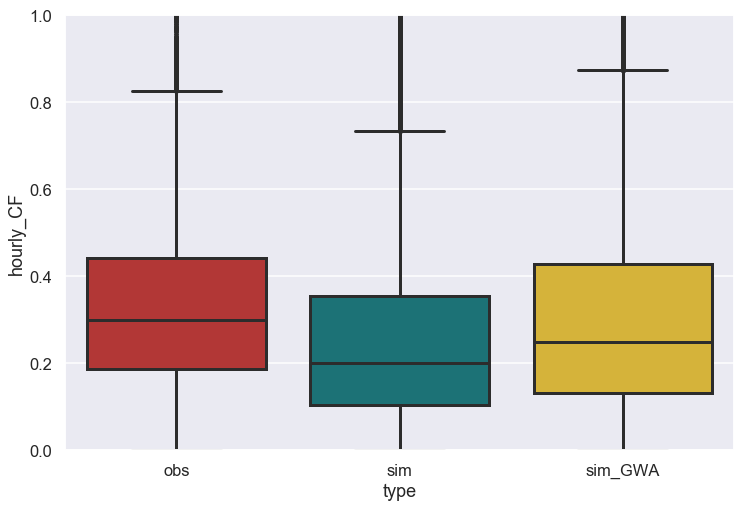

In [824]:
# plot South Africa
CF_ZAFh = CF_ZAF_h.melt(var_name='type',value_name='hourly_CF')
sns.set(style='darkgrid',context='talk')
plt.figure(figsize=(12,8))
ax = sns.boxplot(x='type',y='hourly_CF',data=CF_ZAFh,palette=col_refuel3,linewidth=3)
plt.ylim(0,1)
fig = ax.get_figure()
fig.savefig(south_africa_path+'/results/plots/CFs/ZAF_ERA5_hourly.png')

In [702]:
# boxplots for capes

# melt data for each region and add a region column
CF_ECh = CF_EC_h.melt(var_name='type',value_name='hourly_CF')
CF_ECh['region'] = 'EC'
CF_NCh = CF_NC_h.melt(var_name='type',value_name='hourly_CF')
CF_NCh['region'] = 'NC'
CF_WCh = CF_WC_h.melt(var_name='type',value_name='hourly_CF')
CF_WCh['region'] = 'WC'

# merge regions to one data frame
CF_Ch = pd.concat([CF_ECh,CF_NCh,CF_WCh])

In [703]:
# lengths of time series
print('EC: '+str(CF_ECh.shape[0]))
print('NC: '+str(CF_NCh.shape[0]))
print('WC: '+str(CF_WCh.shape[0]))
print('ZAF: '+str(CF_ZAFh.shape[0]))

EC: 87768
NC: 5727
WC: 71820
ZAF: 87768


In [704]:
CF_Ch_tidy = CF_Ch.melt(id_vars=['region','type'],value_name='hourly_CF').drop(columns={'variable'})

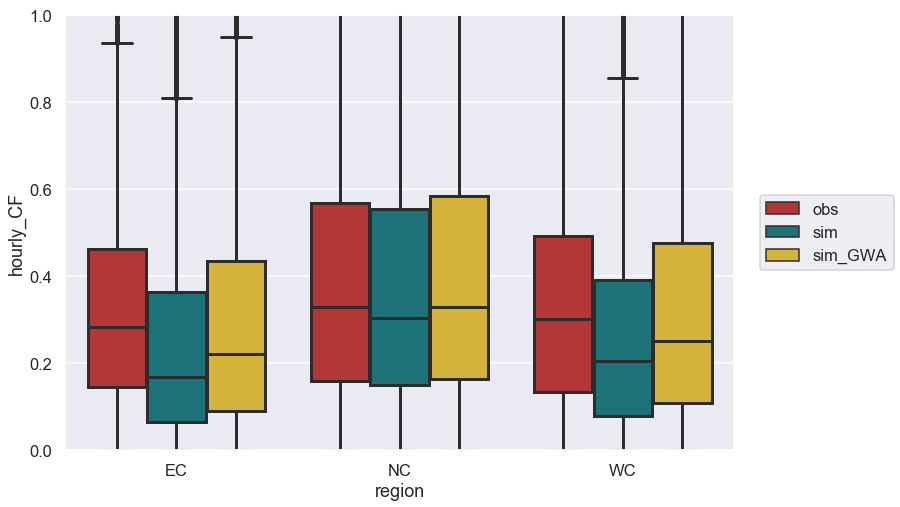

In [832]:
sns.set(style='darkgrid',context='talk')
plt.figure(figsize=(12,8))
ax = sns.boxplot(x='region',y='hourly_CF',hue='type',data=CF_Ch_tidy,palette=col_refuel3,linewidth=3)
ax.legend(loc='center right', bbox_to_anchor=(1.25, 0.5))
plt.ylim(0,1)
fig = ax.get_figure()
fig.savefig(south_africa_path+'/results/plots/CFs/regions_ERA5_hourly.png')

### daily

In [706]:
statsCF_d = pd.DataFrame({'cor':np.nan,
                          'rmse':np.nan,
                          'mbe':np.nan,
                          'avg':np.nan},
                          index = ['EC','EC_GWA','EC_obs',
                                   'NC','NC_GWA','NC_obs',
                                   'WC','WC_GWA','WC_obs',
                                   'ZAF','ZAF_GWA','ZAF_obs'])

In [707]:
statsCF_d.cor = [np.corrcoef(CF_EC_d.obs,CF_EC_d.sim)[0,1],
                 np.corrcoef(CF_EC_d.obs,CF_EC_d.sim_GWA)[0,1],
                 np.nan,
                 np.corrcoef(CF_NC_d.obs,CF_NC_d.sim)[0,1],
                 np.corrcoef(CF_NC_d.obs,CF_NC_d.sim_GWA)[0,1],
                 np.nan,
                 np.corrcoef(CF_WC_d.obs,CF_WC_d.sim)[0,1],
                 np.corrcoef(CF_WC_d.obs,CF_WC_d.sim_GWA)[0,1],
                 np.nan,
                 np.corrcoef(CF_ZAF_d.obs,CF_ZAF_d.sim)[0,1],
                 np.corrcoef(CF_ZAF_d.obs,CF_ZAF_d.sim_GWA)[0,1],
                 np.nan]


In [708]:
statsCF_d.rmse = [np.sqrt(np.mean((np.array(CF_EC_d.obs)-np.array(CF_EC_d.sim))**2)),
                  np.sqrt(np.mean((np.array(CF_EC_d.obs)-np.array(CF_EC_d.sim_GWA))**2)),
                  np.nan,
                  np.sqrt(np.mean((np.array(CF_NC_d.obs)-np.array(CF_NC_d.sim))**2)),
                  np.sqrt(np.mean((np.array(CF_NC_d.obs)-np.array(CF_NC_d.sim_GWA))**2)),
                  np.nan,
                  np.sqrt(np.mean((np.array(CF_WC_d.obs)-np.array(CF_WC_d.sim))**2)),
                  np.sqrt(np.mean((np.array(CF_WC_d.obs)-np.array(CF_WC_d.sim_GWA))**2)),
                  np.nan,
                  np.sqrt(np.mean((np.array(CF_ZAF_d.obs)-np.array(CF_ZAF_d.sim))**2)),
                  np.sqrt(np.mean((np.array(CF_ZAF_d.obs)-np.array(CF_ZAF_d.sim_GWA))**2)),
                  np.nan]

In [709]:
statsCF_d.mbe = [(np.array(CF_EC_d.obs)-np.array(CF_EC_d.sim)).mean(),
                 (np.array(CF_EC_d.obs)-np.array(CF_EC_d.sim_GWA)).mean(),
                 np.nan,
                 (np.array(CF_NC_d.obs)-np.array(CF_NC_d.sim)).mean(),
                 (np.array(CF_NC_d.obs)-np.array(CF_NC_d.sim_GWA)).mean(),
                 np.nan,
                 (np.array(CF_WC_d.obs)-np.array(CF_WC_d.sim)).mean(),
                 (np.array(CF_WC_d.obs)-np.array(CF_WC_d.sim_GWA)).mean(),
                 np.nan,
                 (np.array(CF_ZAF_d.obs)-np.array(CF_ZAF_d.sim)).mean(),
                 (np.array(CF_ZAF_d.obs)-np.array(CF_ZAF_d.sim_GWA)).mean(),
                 np.nan]


In [710]:
statsCF_d.avg = [CF_EC_d.sim.mean(),CF_EC_d.sim_GWA.mean(),CF_EC_d.obs.mean(),
                 CF_NC_d.sim.mean(),CF_NC_d.sim_GWA.mean(),CF_NC_d.obs.mean(),
                 CF_WC_d.sim.mean(),CF_WC_d.sim_GWA.mean(),CF_WC_d.obs.mean(),
                 CF_ZAF_d.sim.mean(),CF_ZAF_d.sim_GWA.mean(),CF_ZAF_d.obs.mean()]


save dataframe with daily results

In [711]:
# hourly and absolute statistics
statsCF_d = statsCF_d.transpose().set_index(pd.Index(['Correlation','RMSE_MWh','MBE_MWh','Mean_MWh']),'parameter')

In [712]:
statsCF_d.round(2).to_csv(south_africa_path+'/results/statsCF_d_ERA5.csv',sep=';')

In [713]:
statsCF_d.round(2)

,EC,EC_GWA,EC_obs,NC,NC_GWA,NC_obs,WC,WC_GWA,WC_obs,ZAF,ZAF_GWA,ZAF_obs
Correlation,0.76,0.73,NaN,0.54,0.54,NaN,0.78,0.81,NaN,0.71,0.68,NaN
RMSE_MWh,0.14,0.13,NaN,0.16,0.15,NaN,0.14,0.11,NaN,0.14,0.13,NaN
MBE_MWh,0.08,0.03,NaN,0.04,0.02,NaN,0.08,0.02,NaN,0.08,0.03,NaN
Mean_MWh,0.26,0.31,0.33,0.38,0.40,0.42,0.30,0.36,0.38,0.27,0.32,0.35


boxplot for South Africa

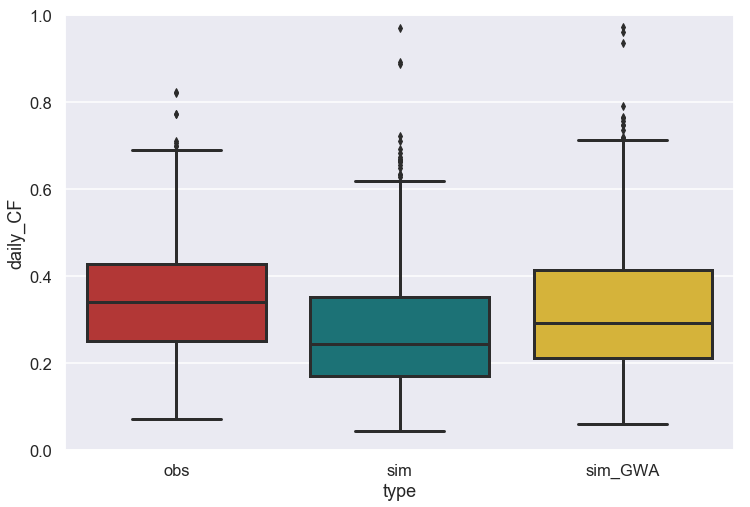

In [827]:
# plot South Africa
CF_ZAFd = CF_ZAF_d.melt(var_name='type',value_name='daily_CF')
sns.set(style='darkgrid',context='talk')
plt.figure(figsize=(12,8))
ax = sns.boxplot(x='type',y='daily_CF',data=CF_ZAFd,palette=col_refuel3,linewidth=3)
plt.ylim(0,1)
fig = ax.get_figure()
fig.savefig(south_africa_path+'/results/plots/CFs/ZAF_ERA5_daily.png')

In [715]:
# boxplots for capes

# melt data for each region and add a region column
CF_ECd = CF_EC_d.melt(var_name='type',value_name='daily_CF')
CF_ECd['region'] = 'EC'
CF_NCd = CF_NC_d.melt(var_name='type',value_name='daily_CF')
CF_NCd['region'] = 'NC'
CF_WCd = CF_WC_d.melt(var_name='type',value_name='daily_CF')
CF_WCd['region'] = 'WC'

# merge regions to one data frame
CF_Cd = pd.concat([CF_ECd,CF_NCd,CF_WCd])

In [716]:
# lengths of time series
print('EC: '+str(CF_ECd.shape[0]))
print('NC: '+str(CF_NCd.shape[0]))
print('WC: '+str(CF_WCd.shape[0]))
print('ZAF: '+str(CF_ZAFd.shape[0]))

EC: 2484
NC: 168
WC: 2127
ZAF: 2484


In [717]:
CF_Cd_tidy = CF_Cd.melt(id_vars=['region','type'],value_name='daily_CF').drop(columns={'variable'})

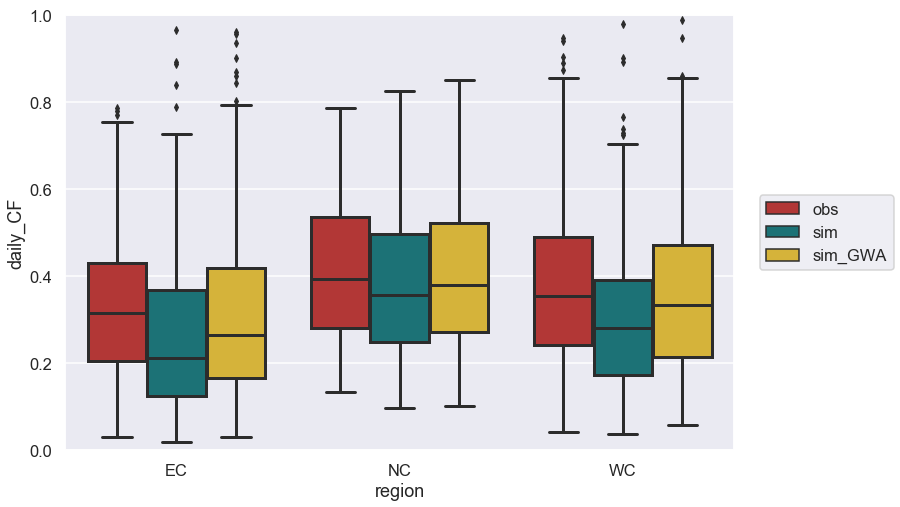

In [831]:
plt.figure(figsize=(12,8))
ax = sns.boxplot(x='region',y='daily_CF',hue='type',data=CF_Cd_tidy,palette=col_refuel3,linewidth=3)
ax.legend(loc='center right', bbox_to_anchor=(1.25, 0.5))
plt.ylim(0,1)
fig = ax.get_figure()
fig.savefig(south_africa_path+'/results/plots/CFs/regions_ERA5_daily.png')

# monthly analysis ZAF - use all days also incomplete ones

In [155]:
ind = production_MW_zaf_ts.index.values.astype('datetime64[M]')
ZAF_comp = production_MW_zaf_ts.groupby(ind).sum()/10**3
ZAF_comp.columns = ['sim_GWh','sim_GWh_GWA','obs','keep']

##### monthly mean capacity for ZAF
##### hourly capacity = mcap_zaf
##### multiplied by 24 and 30 to get monthly capacity
##### unweighted by available data in hours, which then are divided by 24 and 30 to get percentage of hours of month available
##### divided by 1000 to get from MWh to GWh
mcap_ZAFm = mcap_zaf*24*30*pd.DataFrame(ind).groupby(ind).count()/24/30/1000
mcap_ZAFm.columns = ["cap"]

In [156]:
# share of available data - calculate to "upscale" monthly generation
share_avail = pd.DataFrame(ind).groupby(ind).count()/24/30
share_avail.columns = ['share']
ZAF_comp_30d = ZAF_comp.div(share_avail.share,axis=0)

In [157]:
mcap_zafm = mcap_zaf*24*30/1000 # use this as monthly capacity

In [171]:
RMSE = [np.sqrt(((ZAF_comp_30d.sim_GWh- ZAF_comp_30d.obs)**2).mean()),
        np.sqrt(((ZAF_comp_30d.sim_GWh_GWA- ZAF_comp_30d.obs)**2).mean())]

In [172]:
MBE = [(ZAF_comp_30d.sim_GWh - ZAF_comp_30d.obs).mean(),
       (ZAF_comp_30d.sim_GWh_GWA - ZAF_comp_30d.obs).mean()]

In [173]:
stat_zafm = pd.DataFrame({'RMSE':RMSE,
                          'MBE':MBE}, index=['noGWA','GWA'])

In [174]:
stat_zafm

,RMSE,MBE
noGWA,30.666071,13.007352
GWA,46.997501,-40.856901


In [177]:
stat_zafm_rel = ((stat_zafm/mcap_zafm)*100).round(1)

In [178]:
stat_zafm_rel

,RMSE,MBE
noGWA,3.9,1.6
GWA,5.9,-5.2


In [179]:
stat_zafm.to_csv(south_africa_path+'/results/stats_ZAFm_rel_ERA5.csv',sep=';')
stat_zafm_rel.to_csv(south_africa_path+'/results/stats_ZAFm_rel_ERA5.csv',sep=';')

# monthly analysis capes - use all days also incomplete ones

In [192]:
indEC = production_MW_ec_ts.index.values.astype('datetime64[M]')
EC_comp = production_MW_ec_ts.groupby(indEC).sum()/10**3
EC_comp.columns = ['sim_GWh','sim_GWh_GWA','obs','keep']

indNC = production_MW_nc_ts.index.values.astype('datetime64[M]')
NC_comp = production_MW_nc_ts.groupby(indNC).sum()/10**3
NC_comp.columns = ['sim_GWh','sim_GWh_GWA','obs','keep']

indWC = production_MW_wc_ts.index.values.astype('datetime64[M]')
WC_comp = production_MW_wc_ts.groupby(indWC).sum()/10**3
WC_comp.columns = ['sim_GWh','sim_GWh_GWA','obs','keep']

In [193]:
# share of available data - calculate to "upscale" monthly generation
share_availEC = pd.DataFrame(indEC).groupby(indEC).count()/24/30
share_availEC.columns = ['share']
EC_comp_30d = EC_comp.div(share_availEC.share,axis=0)

share_availNC = pd.DataFrame(indNC).groupby(indNC).count()/24/30
share_availNC.columns = ['share']
NC_comp_30d = NC_comp.div(share_availNC.share,axis=0)

share_availWC = pd.DataFrame(indWC).groupby(indWC).count()/24/30
share_availWC.columns = ['share']
WC_comp_30d = WC_comp.div(share_availWC.share,axis=0)

In [196]:
mcap_ecm = mcap_ec*24*30/1000
mcap_ncm = mcap_nc*24*30/1000
mcap_wcm = mcap_wc*24*30/1000

In [197]:
RMSEec = [np.sqrt(((EC_comp_30d.sim_GWh- EC_comp_30d.obs)**2).mean()),
          np.sqrt(((EC_comp_30d.sim_GWh_GWA- EC_comp_30d.obs)**2).mean())]

RMSEnc = [np.sqrt(((NC_comp_30d.sim_GWh- NC_comp_30d.obs)**2).mean()),
          np.sqrt(((NC_comp_30d.sim_GWh_GWA- NC_comp_30d.obs)**2).mean())]

RMSEwc = [np.sqrt(((WC_comp_30d.sim_GWh- WC_comp_30d.obs)**2).mean()),
          np.sqrt(((WC_comp_30d.sim_GWh_GWA- WC_comp_30d.obs)**2).mean())]

In [198]:
MBEec = [(EC_comp_30d.sim_GWh - EC_comp_30d.obs).mean(),
         (EC_comp_30d.sim_GWh_GWA - EC_comp_30d.obs).mean()]

MBEnc = [(NC_comp_30d.sim_GWh - NC_comp_30d.obs).mean(),
         (NC_comp_30d.sim_GWh_GWA - NC_comp_30d.obs).mean()]

MBEwc = [(WC_comp_30d.sim_GWh - WC_comp_30d.obs).mean(),
         (WC_comp_30d.sim_GWh_GWA - WC_comp_30d.obs).mean()]

In [199]:
stat_capem = pd.DataFrame({'RMSE':RMSEec+RMSEnc+RMSEwc,
                           'MBE':MBEec+MBEnc+MBEwc},
                          index=['EC','ECgwa','NC','NCgwa','WC','WCgwa'])

In [200]:
stat_capem

,RMSE,MBE
EC,28.016190,10.690315
ECgwa,32.226233,-27.579724
NC,47.123769,-9.339579
NCgwa,7.513575,-7.505844
WC,14.081068,3.360751
WCgwa,16.573280,-15.859162


In [208]:
stat_capem_rel = stat_capem
stat_capem_rel.iloc[0:2,:] = (stat_capem.iloc[0:2,:]/mcap_ecm*100).round(1)
stat_capem_rel.iloc[2:4,:] = (stat_capem.iloc[2:4,:]/mcap_ncm*100).round(1)
stat_capem_rel.iloc[4:6,:] = (stat_capem.iloc[4:6,:]/mcap_wcm*100).round(1)

In [209]:
stat_capem_rel

,RMSE,MBE
EC,1.0,0.4
ECgwa,1.1,-1.0
NC,12.4,-2.5
NCgwa,2.0,-2.0
WC,5.0,1.2
WCgwa,5.8,-5.6


In [210]:
stat_capem.to_csv(south_africa_path+'/results/stats_CAPESm_rel_ERA5.csv',sep=';')
stat_capem_rel.to_csv(south_africa_path+'/results/stats_CAPESm_rel_ERA5.csv',sep=';')